<a href="https://colab.research.google.com/github/yshr10ic/salary-prediction/blob/master/share_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from pathlib import Path
# 下記パスはご自分の環境に合わせて修正してください
drive_path = Path("/content/drive/My Drive/competition/ProbSpace/salary")

In [0]:
train_path = drive_path / "train_data.csv"
test_path = drive_path / "test_data.csv"

In [0]:
import os
import random
import numpy as np
import pandas as pd
import lightgbm as lgb

In [0]:
# Reference:
# https://www.kaggle.com/bminixhofer/a-validation-framework-impact-of-the-random-seed
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
seed_everything()

In [0]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [0]:
train.shape, test.shape

((21000, 13), (9000, 12))

In [0]:
train.columns

Index(['id', 'position', 'age', 'area', 'sex', 'partner', 'num_child',
       'education', 'service_length', 'study_time', 'commute', 'overtime',
       'salary'],
      dtype='object')

In [0]:
target_col = "salary"
target = train[target_col]
train.drop(columns=[target_col], inplace=True)

In [0]:
drop_cols = ["id"]
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [0]:
cat_features_cols = ["position", "area", "sex", "partner", "education"]

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [0]:
def preprocess(df):
    df["area"] = LabelEncoder().fit_transform(df["area"])
    return df 

In [0]:
train = preprocess(train)
test = preprocess(test)

In [0]:
cat_features_idx = [idx for idx, col in enumerate(train.columns) if col in cat_features_cols]

In [0]:
cat_features_idx

[0, 2, 3, 4, 6]

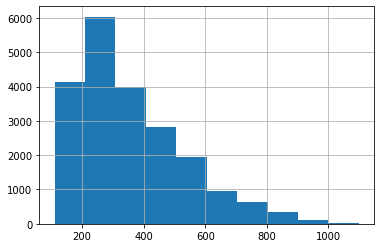

In [0]:
target.hist()

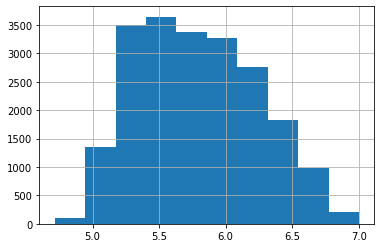

In [0]:
target.map(np.log1p).hist()

In [0]:
target = target.map(np.log1p)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.1, random_state=42)

In [0]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [0]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'fair',
    'metric': 'fair',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'n_estimators':20000,
    'early_stopping_rounds':200,
    'seed': 42
}

In [0]:
model = lgb.train(params,
                  lgb_train,
                  valid_names=['train', 'valid'],
                  valid_sets=[lgb_train, lgb_valid],
                  categorical_feature=cat_features_idx,
                  verbose_eval=200)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 2, 3, 4, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[200]	train's fair: 0.00591529	valid's fair: 0.00584272
[400]	train's fair: 0.00383766	valid's fair: 0.00388675
[600]	train's fair: 0.00341535	valid's fair: 0.00358709
[800]	train's fair: 0.00321057	valid's fair: 0.00348837
[1000]	train's fair: 0.00306264	valid's fair: 0.00343574
[1200]	train's fair: 0.00293848	valid's fair: 0.00338688
[1400]	train's fair: 0.00283491	valid's fair: 0.00337048
[1600]	train's fair: 0.00274115	valid's fair: 0.00335145
[1800]	train's fair: 0.00265499	valid's fair: 0.0033412
[2000]	train's fair: 0.00257815	valid's fair: 0.00333537
[2200]	train's fair: 0.0025007	valid's fair: 0.00332757
[2400]	train's fair: 0.00242746	valid's fair: 0.00331816
[2600]	train's fair: 0.00236282	valid's fair: 0.00331732
[2800]	train's fair: 0.00230092	valid's fair: 0.003314
[3000]	train's fair: 0.00224055	valid's fair: 0.0033139
Early stopping, best iteration is:
[2890]	train's fair: 0.0022729	valid's fair: 0.00331216


In [0]:
predicts = np.expm1(model.predict(test))

In [0]:
pd.DataFrame({"id": range(len(predicts)), "y": predicts }).to_csv("submission.csv", index=False)